# A/B Compartment Calling

The data used here is from Su et al, 2020. In the first part of the paper, they adopted a high-resolution whole-chromosome imaging approach to image chromosome 2 and chromosome 21 from IMR90 cell line. Chromosome 2 has more compartment variations and is imaged at a resolution of 250kb for thousands of traces. We chose this as the benchmarking data.

Su, J.-H., Zheng, P., Kinrot, S. S., Bintu, B. & Zhuang, X. Genome-Scale Imaging of the 3D Organization and Transcriptional Activity of Chromatin. Cell 182, 1641-1659.e26 (2020).


In [1]:
import os
import importlib
import shutil
import warnings
from itertools import combinations
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns

import zarr
import dask.array as da

from utils.data import DataTree
import snapfish2 as sf
importlib.reload(sf)
dtree = DataTree("../data")

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
out_dire = "../123ACElog/013125"

## 1000 traces from chromosome 2 p-arm

In [4]:
parm_path = "fof_ct_chromosome2_p-arm_replicate.tsv"
mfr = sf.MulFish(pd.read_csv(f"../data/su_cell_2020/{parm_path}"))

In [7]:
carr = sf.utils.load.ChromArray(mfr[("Trace_ID",0,1000)])
carr.load_write("test_da")

In [8]:
med_sq_raw = da.nanmedian(da.square(carr.arr), axis=0).compute()
med_dist_raw = da.nanmedian(da.sqrt(
    da.sum(da.square(carr.arr), axis=1)    
), axis=0).compute()
carr.normalize_inplace()
med_sq_norm = da.nanmedian(da.square(carr.arr), axis=0).compute()
med_dist_norm = da.nanmedian(da.sqrt(
    da.sum(da.square(carr.arr), axis=1)    
), axis=0).compute()

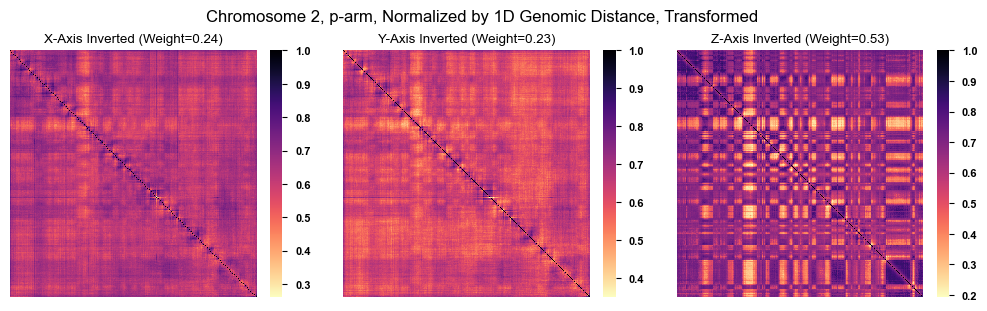

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(10,3))
fig.suptitle("Chromosome 2, p-arm, Normalized by 1D Genomic Distance, Transformed")
wts = carr.axis_weights()
for axis, mat, ax, wt in zip(["X", "Y", "Z"], med_sq_norm, axes, wts):
    sf.pl.pairwise_heatmap(np.exp(-mat), ax=ax, vmax=1, cmap="magma_r",
                           title=f"{axis}-Axis Inverted (Weight={wt:.2f})")

In [10]:
raw = mfr[("Trace_ID",0,1000)]

In [11]:
abc = sf.domain.ABCaller(raw, 0, "carr")
res1 = abc.by_first_pc(cutoff=500, sigma=1.9)

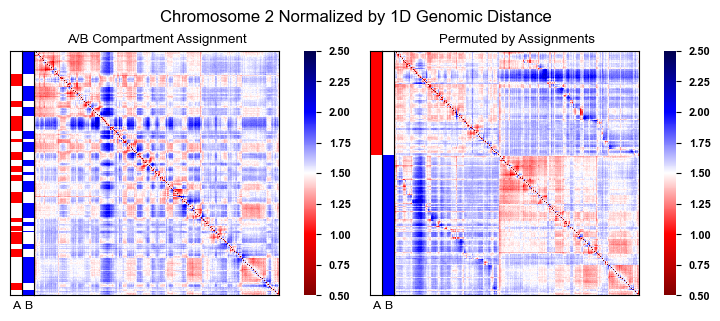

In [12]:
cpmt_arr = res1["chr2"][1]

fig, axes = plt.subplots(1, 2, figsize=(7.2,3))
fig.suptitle("Chromosome 2 Normalized by 1D Genomic Distance")
sf.pl.pairwise_heatmap(med_dist_norm, ax=axes[0], 
                       vmin=.5, vmax=2.5, rasterized=True)
axes[0].set(title="A/B Compartment Assignment")
sf.pl.plot_AB_bars(cpmt_arr, axes[0])

idx = np.arange(len(cpmt_arr), dtype="int64")
idx = np.concatenate([idx[cpmt_arr==0], idx[cpmt_arr==1]])
perm_cpmt = np.concatenate([cpmt_arr[cpmt_arr==0], cpmt_arr[cpmt_arr==1]])
sf.pl.pairwise_heatmap(med_dist_norm[idx][:,idx], ax=axes[1], 
                       vmin=.5, vmax=2.5, rasterized=True)
sf.pl.plot_AB_bars(perm_cpmt, axes[1])
axes[1].set(title="Permuted by Assignments")
out_name = os.path.join(out_dire, "chr2_parm_pc1_raw.pdf")
fig.savefig(out_name, bbox_inches="tight")

In [13]:
abc = sf.domain.ABCaller(raw, 0, "carr")
res2 = abc.by_axes_pc()

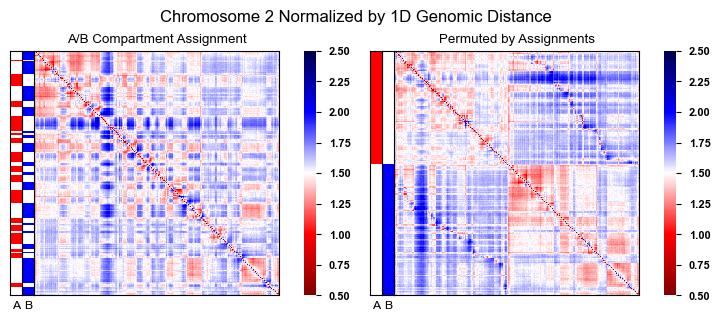

In [14]:
cpmt_arr = res2["chr2"][1]

fig, axes = plt.subplots(1, 2, figsize=(7.2,3))
fig.suptitle("Chromosome 2 Normalized by 1D Genomic Distance")
sf.pl.pairwise_heatmap(med_dist_norm, ax=axes[0], 
                       vmin=.5, vmax=2.5, rasterized=True)
axes[0].set(title="A/B Compartment Assignment")
sf.pl.plot_AB_bars(cpmt_arr, axes[0])

idx = np.arange(len(cpmt_arr), dtype="int64")
idx = np.concatenate([idx[cpmt_arr==0], idx[cpmt_arr==1]])
perm_cpmt = np.concatenate([cpmt_arr[cpmt_arr==0], cpmt_arr[cpmt_arr==1]])
sf.pl.pairwise_heatmap(med_dist_norm[idx][:,idx], ax=axes[1], 
                       vmin=.5, vmax=2.5, rasterized=True)
sf.pl.plot_AB_bars(perm_cpmt, axes[1])
axes[1].set(title="Permuted by Assignments")
out_name = os.path.join(out_dire, "chr2_parm_kmeans_raw.pdf")
fig.savefig(out_name, bbox_inches="tight")

In [15]:
from utils.data import filter_save
df = pd.Series(carr.d1d).to_frame("1D")
df["Su et al"] = res1["chr2"][1]
df["SnapFISH2"] = res2["chr2"][1].astype("int64")
d1df = mfr.data[[
    "Chrom", "Chrom_Start", "Chrom_End"
]].drop_duplicates()

for marker in dtree["chipseq_imr90"]:
    chip_df = pd.read_csv(
        dtree["chipseq_imr90",marker], sep="\t", 
        header=None, usecols=[0, 1, 2]
    )
    chip_df.columns = ["c1", "s1", "e1"]
    chipseq_marked = filter_save(chip_df, d1df)["s1"].values

    df[marker] = df["1D"].isin(chipseq_marked)

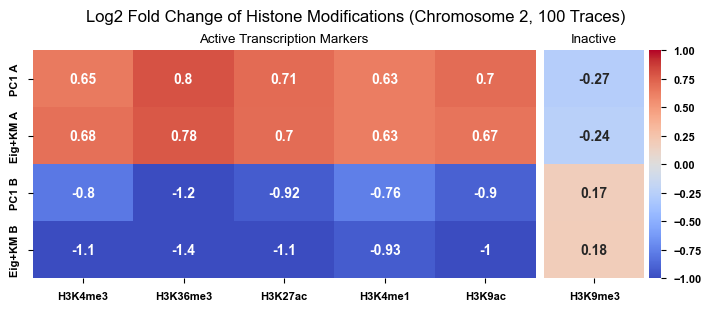

In [17]:
expc = df.drop(["1D", "SnapFISH2", "Su et al"], axis=1).sum()/len(df)
summ1 = np.log2(df.drop(
    ["1D", "SnapFISH2"], axis=1
).groupby("Su et al").mean()/expc)
summ2 = np.log2(df.drop(
    ["1D", "Su et al"], axis=1    
).groupby("SnapFISH2").mean()/expc)

up_rglt = ["H3K4me3", "H3K36me3", "H3K27ac", "H3K4me1", "H3K9ac"]
down_rglt = ["H3K9me3"]
plt_df = pd.concat([summ1.T, summ2.T], axis=1)
plt_df.columns = ["PC1 A", "PC1 B", "Eig+KM A", "Eig+KM B"]
plt_df = plt_df[["PC1 A", "Eig+KM A", "PC1 B", "Eig+KM B"]]
fig, axes = plt.subplots(1, 2, figsize=(7,3), width_ratios=[len(up_rglt),len(down_rglt)])
sns.heatmap(plt_df.T[up_rglt], vmin=-1, vmax=1, annot=True, 
            cmap="coolwarm", cbar=False, ax=axes[0])
axes[0].set(title="Active Transcription Markers")
sns.heatmap(plt_df.T[down_rglt], vmin=-1, vmax=1, annot=True, 
            cmap="coolwarm", cbar=True, yticklabels=False, ax=axes[1])
axes[1].set(title="Inactive")
fig.suptitle("Log2 Fold Change of Histone Modifications (Chromosome 2, 100 Traces)")
out_name = os.path.join(out_dire, "chr2_parm_1ktr_log2.pdf")
fig.savefig(out_name, bbox_inches="tight")

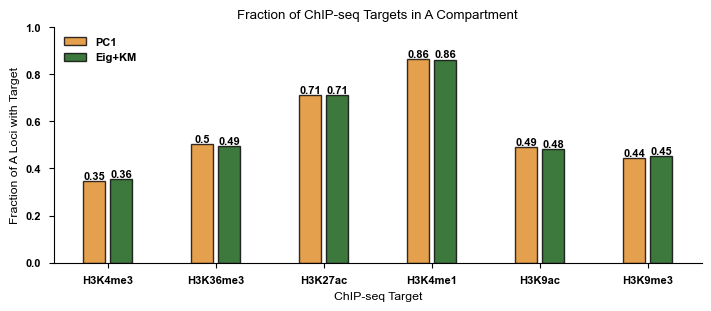

In [18]:
summ1_m = df.drop(["1D", "SnapFISH2"], axis=1).groupby("Su et al").mean()
summ1_m = summ1_m[up_rglt + down_rglt]
summ2_m = df.drop(["1D", "Su et al"], axis=1).groupby("SnapFISH2").mean()
summ2_m = summ2_m[up_rglt + down_rglt]
plt_df1 = summ1_m.T.reset_index(names=["Marker"]).melt(
    id_vars=["Marker"], var_name="Cpmt", value_name="frac"
)
plt_df1["Cpmt"] = plt_df1["Cpmt"].map({0:"A", 1:"B"})
plt_df1["Method"] = "PC1"
plt_df2 = summ2_m.T.reset_index(names=["Marker"]).melt(
    id_vars=["Marker"], var_name="Cpmt", value_name="frac"
)
plt_df2["Cpmt"] = plt_df2["Cpmt"].map({0:"A", 1:"B"})
plt_df2["Method"] = "Eig+KM"
plt_df = pd.concat([plt_df1, plt_df2], ignore_index=True)

fig, ax = plt.subplots(figsize=(7, 3))
sns.barplot(
    plt_df[plt_df["Cpmt"]=="A"], x="Marker", y="frac", hue="Method",  ax=ax, 
    width=.5, dodge=10, gap=0.2, alpha=.8, edgecolor="k", linewidth=1,
    palette={"PC1": "darkorange", "Eig+KM": "darkgreen"},
)
ax.bar_label(
    ax.containers[0], labels=ax.containers[0].datavalues.round(2), fontsize=8
)
ax.bar_label(
    ax.containers[1], labels=ax.containers[1].datavalues.round(2), fontsize=8
)
ax.legend(loc="upper left")
ax.set(xlabel="ChIP-seq Target", ylabel="Fraction of A Loci with Target")
ax.set(ylim=(0,1), title="Fraction of ChIP-seq Targets in A Compartment")
out_name = os.path.join(out_dire, "chr2_parm_1ktr_frac.pdf")
fig.savefig(out_name, bbox_inches="tight")

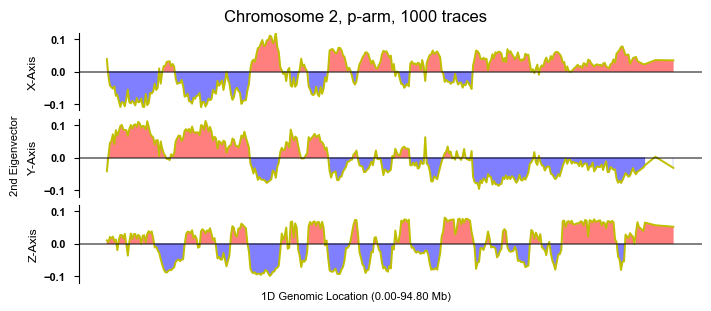

In [68]:
df = abc.to_bedpe(res2)

fig, axes = plt.subplots(3, 1, figsize=(7, 3), sharex=True)
for i, c in enumerate(["x", "y", "z"]):
    sns.lineplot(df, x="s1", y=f"eig_{c}", color="y", ax=axes[i])
    axes[i].spines['bottom'].set_visible(False)
    xmin, xmax = axes[i].get_xlim()
    axes[i].hlines([0], xmin=xmin, xmax=xmax, color="k", alpha=0.5)
    axes[i].set(xlim=(xmin, xmax), ylim=(-0.12, 0.12), xticks=[])
    axes[i].set(ylabel=f"{c}-Axis".title())
    axes[i].fill_between(
        df["s1"], df[f"eig_{c}"], 0, where=df[f"eig_{c}"]>=0, 
        alpha=0.5, color="r"
    )
    axes[i].fill_between(
        df["s1"], df[f"eig_{c}"], 0, where=df[f"eig_{c}"]<=0, 
        alpha=0.5, color="b"
    )
dmin, dmax = df["s1"].min()/1e6, df["e1"].max()/1e6
fig.supxlabel(f"1D Genomic Location ({dmin:.2f}-{dmax:.2f} Mb)", fontsize=8)
fig.supylabel("2nd Eigenvector", fontsize=8)
fig.suptitle("Chromosome 2, p-arm, 1000 traces")
out_name = os.path.join(out_dire, "chr2_parm_1ktr_eig.pdf")
fig.savefig(out_name, bbox_inches="tight")

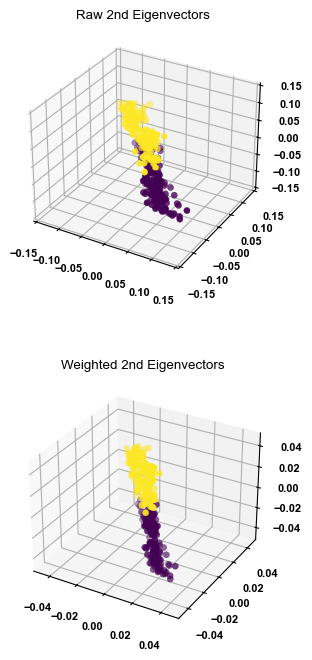

In [74]:
df = abc.to_bedpe(res2)
fig = plt.figure(figsize=(3, 7))
ax = fig.add_subplot(2, 1, 1, projection="3d")
ax.scatter(df["eig_x"], df["eig_y"], df["eig_z"], c=df["cpmt"])
ax.set(xlim=(-.15,.15), ylim=(-.15,.15), zlim=(-.15,.15))
ax.set(title="Raw 2nd Eigenvectors")
ax = fig.add_subplot(2, 1, 2, projection="3d")
ax.scatter(df["wteig_x"], df["wteig_y"], df["wteig_z"], c=df["cpmt"])
ax.set(xlim=(-.05,.05), ylim=(-.05,.05), zlim=(-.05,.05))
ax.set(title="Weighted 2nd Eigenvectors")
out_name = os.path.join(out_dire, "chr2_parm_1ktr_eig_scatter.pdf")
fig.savefig(out_name, bbox_inches="tight")

## Varying number of cells

In [5]:
carr = sf.utils.load.ChromArray(mfr[("Trace_ID",0,30)])
carr.load_write("test_da")

In [6]:
med_sq_raw = da.nanmedian(da.square(carr.arr), axis=0).compute()
med_dist_raw = da.nanmedian(da.sqrt(
    da.sum(da.square(carr.arr), axis=1)    
), axis=0).compute()
carr.normalize_inplace()
med_sq_norm = da.nanmedian(da.square(carr.arr), axis=0).compute()
med_dist_norm = da.nanmedian(da.sqrt(
    da.sum(da.square(carr.arr), axis=1)    
), axis=0).compute()

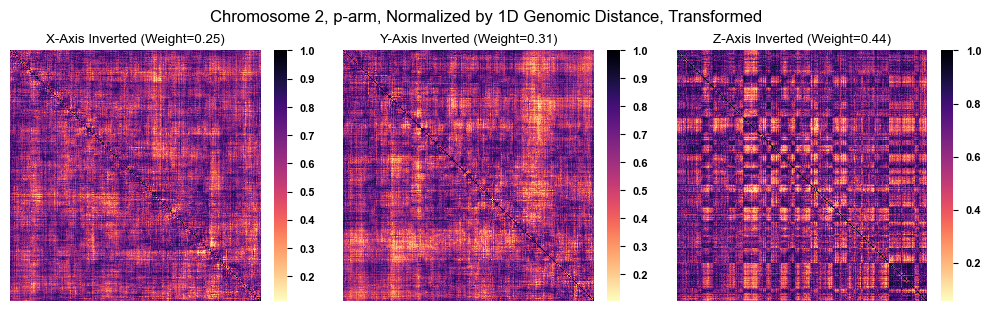

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(10,3))
fig.suptitle("Chromosome 2, p-arm, Normalized by 1D Genomic Distance, Transformed")
wts = carr.axis_weights()
for axis, mat, ax, wt in zip(["X", "Y", "Z"], med_sq_norm, axes, wts):
    sf.pl.pairwise_heatmap(np.exp(-mat), ax=ax, vmax=1, cmap="magma_r", rasterized=True,
                           title=f"{axis}-Axis Inverted (Weight={wt:.2f})")
out_name = os.path.join(out_dire, "chr2_parm_30tr_pdiff.pdf")
fig.savefig(out_name, bbox_inches="tight")

In [8]:
raw = mfr[("Trace_ID",0,30)]

In [9]:
abc = sf.domain.ABCaller(raw, 0, "carr")
res1 = abc.by_first_pc(cutoff=500, sigma=1.9)

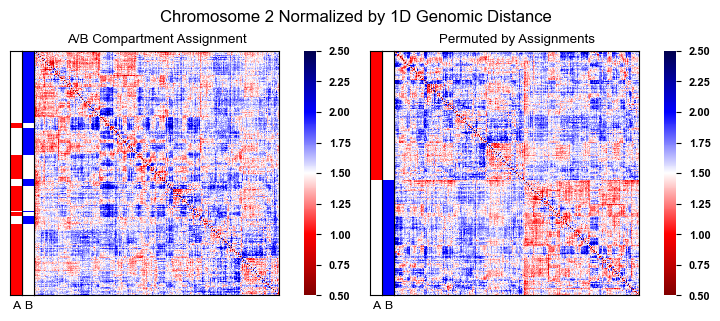

In [10]:
cpmt_arr = res1["chr2"][1]

fig, axes = plt.subplots(1, 2, figsize=(7.2,3))
fig.suptitle("Chromosome 2 Normalized by 1D Genomic Distance")
sf.pl.pairwise_heatmap(med_dist_norm, ax=axes[0], 
                       vmin=.5, vmax=2.5, rasterized=True)
axes[0].set(title="A/B Compartment Assignment")
sf.pl.plot_AB_bars(cpmt_arr, axes[0])

idx = np.arange(len(cpmt_arr), dtype="int64")
idx = np.concatenate([idx[cpmt_arr==0], idx[cpmt_arr==1]])
perm_cpmt = np.concatenate([cpmt_arr[cpmt_arr==0], cpmt_arr[cpmt_arr==1]])
sf.pl.pairwise_heatmap(med_dist_norm[idx][:,idx], ax=axes[1], 
                       vmin=.5, vmax=2.5, rasterized=True)
sf.pl.plot_AB_bars(perm_cpmt, axes[1])
axes[1].set(title="Permuted by Assignments")
out_name = os.path.join(out_dire, "chr2_parm_30tr_pc1_raw.pdf")
fig.savefig(out_name, bbox_inches="tight")

In [11]:
abc = sf.domain.ABCaller(raw, 0, "carr")
res2 = abc.by_axes_pc()

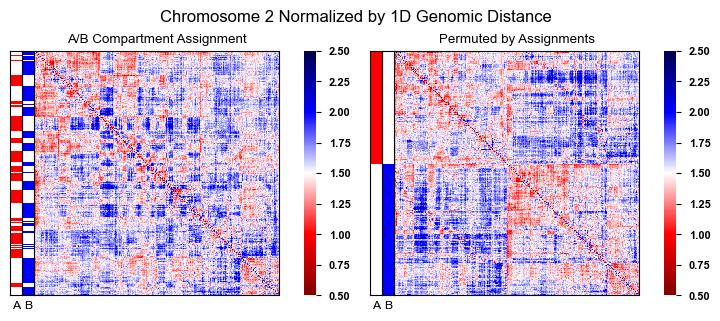

In [12]:
cpmt_arr = res2["chr2"][1]

fig, axes = plt.subplots(1, 2, figsize=(7.2,3))
fig.suptitle("Chromosome 2 Normalized by 1D Genomic Distance")
sf.pl.pairwise_heatmap(med_dist_norm, ax=axes[0], 
                       vmin=.5, vmax=2.5, rasterized=True)
axes[0].set(title="A/B Compartment Assignment")
sf.pl.plot_AB_bars(cpmt_arr, axes[0])

idx = np.arange(len(cpmt_arr), dtype="int64")
idx = np.concatenate([idx[cpmt_arr==0], idx[cpmt_arr==1]])
perm_cpmt = np.concatenate([cpmt_arr[cpmt_arr==0], cpmt_arr[cpmt_arr==1]])
sf.pl.pairwise_heatmap(med_dist_norm[idx][:,idx], ax=axes[1], 
                       vmin=.5, vmax=2.5, rasterized=True)
sf.pl.plot_AB_bars(perm_cpmt, axes[1])
axes[1].set(title="Permuted by Assignments")
out_name = os.path.join(out_dire, "chr2_parm_30tr_kmeans_raw.pdf")
fig.savefig(out_name, bbox_inches="tight")

In [13]:
from utils.data import filter_save
df = pd.Series(carr.d1d).to_frame("1D")
df["Su et al"] = res1["chr2"][1]
df["SnapFISH2"] = res2["chr2"][1].astype("int64")
d1df = mfr.data[[
    "Chrom", "Chrom_Start", "Chrom_End"
]].drop_duplicates()

for marker in dtree["chipseq_imr90"]:
    chip_df = pd.read_csv(
        dtree["chipseq_imr90",marker], sep="\t", 
        header=None, usecols=[0, 1, 2]
    )
    chip_df.columns = ["c1", "s1", "e1"]
    chipseq_marked = filter_save(chip_df, d1df)["s1"].values

    df[marker] = df["1D"].isin(chipseq_marked)

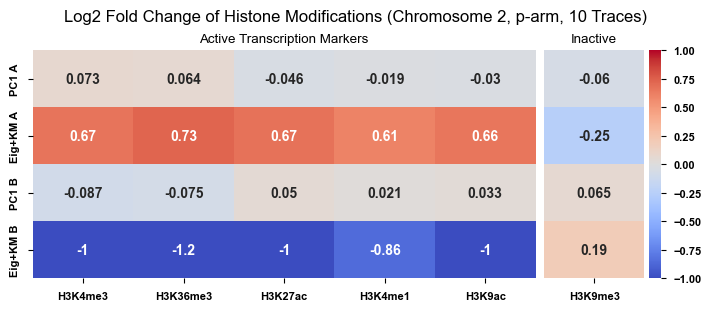

In [14]:
expc = df.drop(["1D", "SnapFISH2", "Su et al"], axis=1).sum()/len(df)
summ1 = np.log2(df.drop(
    ["1D", "SnapFISH2"], axis=1
).groupby("Su et al").mean()/expc)
summ2 = np.log2(df.drop(
    ["1D", "Su et al"], axis=1    
).groupby("SnapFISH2").mean()/expc)

up_rglt = ["H3K4me3", "H3K36me3", "H3K27ac", "H3K4me1", "H3K9ac"]
down_rglt = ["H3K9me3"]
plt_df = pd.concat([summ1.T, summ2.T], axis=1)
plt_df.columns = ["PC1 A", "PC1 B", "Eig+KM A", "Eig+KM B"]
plt_df = plt_df[["PC1 A", "Eig+KM A", "PC1 B", "Eig+KM B"]]
fig, axes = plt.subplots(1, 2, figsize=(7,3), width_ratios=[len(up_rglt),len(down_rglt)])
sns.heatmap(plt_df.T[up_rglt], vmin=-1, vmax=1, annot=True, 
            cmap="coolwarm", cbar=False, ax=axes[0])
axes[0].set(title="Active Transcription Markers")
sns.heatmap(plt_df.T[down_rglt], vmin=-1, vmax=1, annot=True, 
            cmap="coolwarm", cbar=True, yticklabels=False, ax=axes[1])
axes[1].set(title="Inactive")
fig.suptitle("Log2 Fold Change of Histone Modifications (Chromosome 2, p-arm, 10 Traces)")
out_name = os.path.join(out_dire, "chr2_parm_30tr_log2.pdf")
fig.savefig(out_name, bbox_inches="tight")

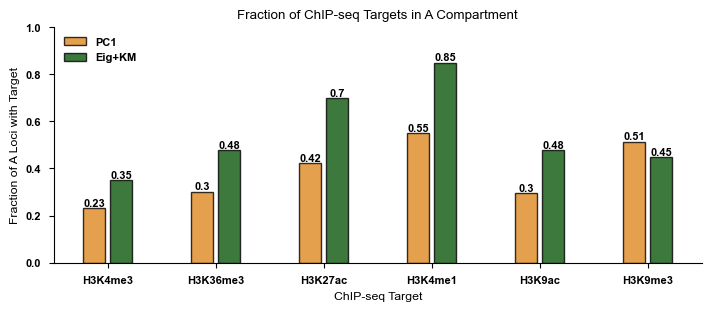

In [15]:
summ1_m = df.drop(["1D", "SnapFISH2"], axis=1).groupby("Su et al").mean()
summ1_m = summ1_m[up_rglt + down_rglt]
summ2_m = df.drop(["1D", "Su et al"], axis=1).groupby("SnapFISH2").mean()
summ2_m = summ2_m[up_rglt + down_rglt]
plt_df1 = summ1_m.T.reset_index(names=["Marker"]).melt(
    id_vars=["Marker"], var_name="Cpmt", value_name="frac"
)
plt_df1["Cpmt"] = plt_df1["Cpmt"].map({0:"A", 1:"B"})
plt_df1["Method"] = "PC1"
plt_df2 = summ2_m.T.reset_index(names=["Marker"]).melt(
    id_vars=["Marker"], var_name="Cpmt", value_name="frac"
)
plt_df2["Cpmt"] = plt_df2["Cpmt"].map({0:"A", 1:"B"})
plt_df2["Method"] = "Eig+KM"
plt_df = pd.concat([plt_df1, plt_df2], ignore_index=True)

fig, ax = plt.subplots(figsize=(7, 3))
sns.barplot(
    plt_df[plt_df["Cpmt"]=="A"], x="Marker", y="frac", hue="Method",  ax=ax, 
    width=.5, dodge=10, gap=0.2, alpha=.8, edgecolor="k", linewidth=1,
    palette={"PC1": "darkorange", "Eig+KM": "darkgreen"},
)
ax.bar_label(
    ax.containers[0], labels=ax.containers[0].datavalues.round(2), fontsize=8
)
ax.bar_label(
    ax.containers[1], labels=ax.containers[1].datavalues.round(2), fontsize=8
)
ax.legend(loc="upper left")
ax.set(xlabel="ChIP-seq Target", ylabel="Fraction of A Loci with Target")
ax.set(ylim=(0,1), title="Fraction of ChIP-seq Targets in A Compartment")
out_name = os.path.join(out_dire, "chr2_parm_30tr_frac.pdf")
fig.savefig(out_name, bbox_inches="tight")

## 100 traces from chromosome 2

In [5]:
mfr = sf.tl.MulFish(pd.read_csv("../data/su_cell_2020/fof_ct_chromosome2.tsv"))
# chr_df_pivoted, arr = sf.utils.to_very_wide(mfr.data)  # kernel died

In [4]:
carr = sf.utils.load.ChromArray(mfr[("Trace_ID",0,100)])
carr.load_write("test_da")
print(f"Normalized={carr.normalized}, {da.sum(~da.isnan(carr.arr)).compute()}")
# carr.normalize_inplace()
# print(f"Normalized={carr.normalized}, {da.sum(~da.isnan(carr.arr)).compute()}")

Normalized=False, 262150065


In [5]:
med_sq_raw = da.nanmedian(da.square(carr.arr), axis=0).compute()
med_dist_raw = da.nanmedian(da.sqrt(
    da.sum(da.square(carr.arr), axis=1)    
), axis=0).compute()
carr.normalize_inplace()
med_sq_norm = da.nanmedian(da.square(carr.arr), axis=0).compute()
med_dist_norm = da.nanmedian(da.sqrt(
    da.sum(da.square(carr.arr), axis=1)    
), axis=0).compute()

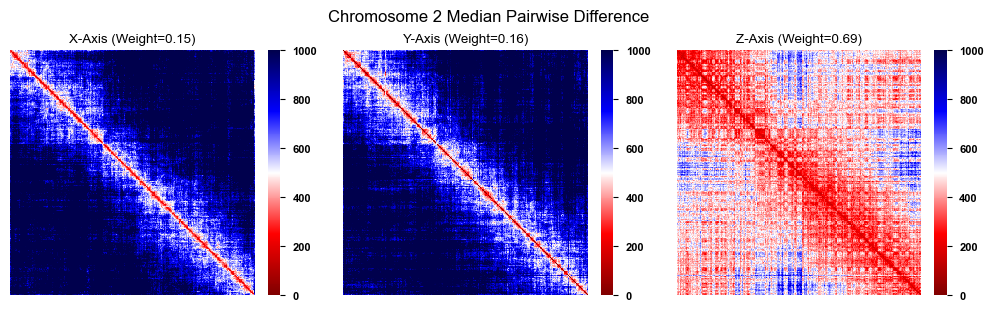

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(10,3))
fig.suptitle("Chromosome 2 Median Pairwise Difference")
wts = carr.axis_weights()
for axis, mat, ax, wt in zip(["X", "Y", "Z"], med_sq_raw, axes, wts):
    sf.pl.pairwise_heatmap(mat**.5, ax=ax, vmax=1000, rasterized=True,
                           title=f"{axis}-Axis (Weight={wt:.2f})")
out_name = os.path.join(out_dire, "chr2_pairwise_diff.pdf")
fig.savefig(out_name, bbox_inches="tight")

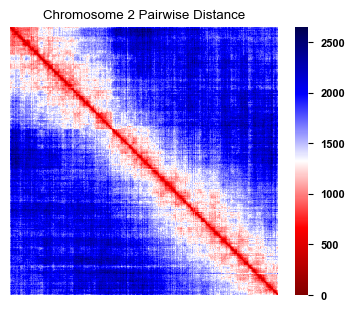

In [29]:
fig, ax = plt.subplots(figsize=(4,3))
sf.pl.pairwise_heatmap(med_dist_raw, ax=ax, rasterized=True)
ax.set(title="Chromosome 2 Pairwise Distance")
out_name = os.path.join(out_dire, "chr2_pairwise_dist.pdf")
fig.savefig(out_name, bbox_inches="tight")

In [16]:
raw = mfr[("Trace_ID",0,100)]

In [17]:
abc = sf.domain.ABCaller(raw, 0, "carr")
res1 = abc.by_first_pc(cutoff=500, sigma=1.9)

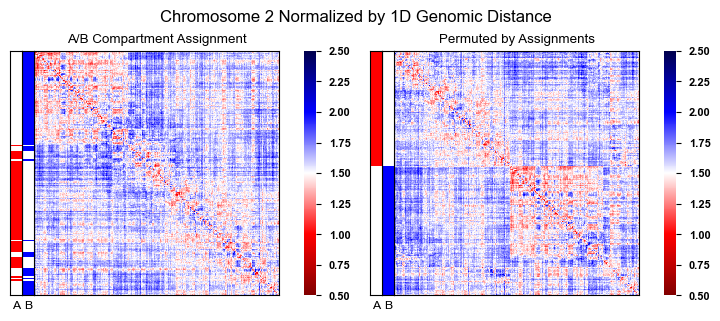

In [27]:
cpmt_arr = res1["chr2"][1]

fig, axes = plt.subplots(1, 2, figsize=(7.2,3))
fig.suptitle("Chromosome 2 Normalized by 1D Genomic Distance")
sf.pl.pairwise_heatmap(med_dist_norm, ax=axes[0], 
                       vmin=.5, vmax=2.5, rasterized=True)
axes[0].set(title="A/B Compartment Assignment")
sf.pl.plot_AB_bars(cpmt_arr, axes[0])

idx = np.arange(len(cpmt_arr), dtype="int64")
idx = np.concatenate([idx[cpmt_arr==0], idx[cpmt_arr==1]])
perm_cpmt = np.concatenate([cpmt_arr[cpmt_arr==0], cpmt_arr[cpmt_arr==1]])
sf.pl.pairwise_heatmap(med_dist_norm[idx][:,idx], ax=axes[1], 
                       vmin=.5, vmax=2.5, rasterized=True)
sf.pl.plot_AB_bars(perm_cpmt, axes[1])
axes[1].set(title="Permuted by Assignments")
out_name = os.path.join(out_dire, "chr2_pc1_raw.pdf")
fig.savefig(out_name, bbox_inches="tight")

In [22]:
abc = sf.domain.ABCaller(raw, 0, "carr")
res2 = abc.by_axes_pc()

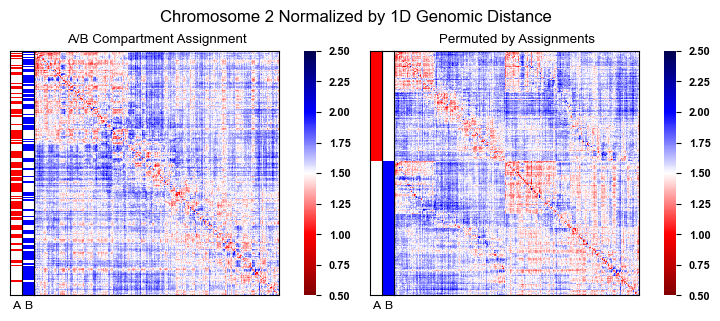

In [31]:
cpmt_arr = res2["chr2"][1]

fig, axes = plt.subplots(1, 2, figsize=(7.2,3))
fig.suptitle("Chromosome 2 Normalized by 1D Genomic Distance")
sf.pl.pairwise_heatmap(med_dist_norm, ax=axes[0], 
                       vmin=.5, vmax=2.5, rasterized=True)
axes[0].set(title="A/B Compartment Assignment")
sf.pl.plot_AB_bars(cpmt_arr, axes[0])

idx = np.arange(len(cpmt_arr), dtype="int64")
idx = np.concatenate([idx[cpmt_arr==0], idx[cpmt_arr==1]])
perm_cpmt = np.concatenate([cpmt_arr[cpmt_arr==0], cpmt_arr[cpmt_arr==1]])
sf.pl.pairwise_heatmap(med_dist_norm[idx][:,idx], ax=axes[1], 
                       vmin=.5, vmax=2.5, rasterized=True)
sf.pl.plot_AB_bars(perm_cpmt, axes[1])
axes[1].set(title="Permuted by Assignments")
out_name = os.path.join(out_dire, "chr2_kmeans_raw.pdf")
fig.savefig(out_name, bbox_inches="tight")

In [34]:
from utils.data import filter_save
df = pd.Series(carr.d1d).to_frame("1D")
df["Su et al"] = res1["chr2"][1]
df["SnapFISH2"] = res2["chr2"][1].astype("int64")
d1df = mfr.data[[
    "Chrom", "Chrom_Start", "Chrom_End"
]].drop_duplicates()

for marker in dtree["chipseq_imr90"]:
    chip_df = pd.read_csv(
        dtree["chipseq_imr90",marker], sep="\t", 
        header=None, usecols=[0, 1, 2]
    )
    chip_df.columns = ["c1", "s1", "e1"]
    chipseq_marked = filter_save(chip_df, d1df)["s1"].values

    df[marker] = df["1D"].isin(chipseq_marked)

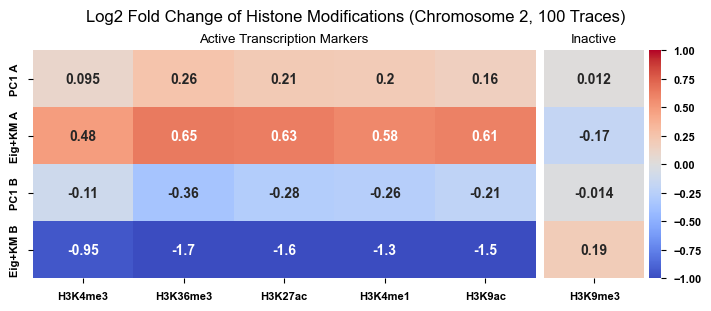

In [114]:
expc = df.drop(["1D", "SnapFISH2", "Su et al"], axis=1).sum()/len(df)
summ1 = np.log2(df.drop(
    ["1D", "SnapFISH2"], axis=1
).groupby("Su et al").mean()/expc)
summ2 = np.log2(df.drop(
    ["1D", "Su et al"], axis=1    
).groupby("SnapFISH2").mean()/expc)

up_rglt = ["H3K4me3", "H3K36me3", "H3K27ac", "H3K4me1", "H3K9ac"]
down_rglt = ["H3K9me3"]
plt_df = pd.concat([summ1.T, summ2.T], axis=1)
plt_df.columns = ["PC1 B", "PC1 A", "Eig+KM B", "Eig+KM A"]
plt_df = plt_df[["PC1 A", "Eig+KM A", "PC1 B", "Eig+KM B"]]
fig, axes = plt.subplots(1, 2, figsize=(7,3), width_ratios=[len(up_rglt),len(down_rglt)])
sns.heatmap(plt_df.T[up_rglt], vmin=-1, vmax=1, annot=True, 
            cmap="coolwarm", cbar=False, ax=axes[0])
axes[0].set(title="Active Transcription Markers")
sns.heatmap(plt_df.T[down_rglt], vmin=-1, vmax=1, annot=True, 
            cmap="coolwarm", cbar=True, yticklabels=False, ax=axes[1])
axes[1].set(title="Inactive")
fig.suptitle("Log2 Fold Change of Histone Modifications (Chromosome 2, 100 Traces)")
out_name = os.path.join(out_dire, "chr2_100tr_log2.pdf")
fig.savefig(out_name, bbox_inches="tight")

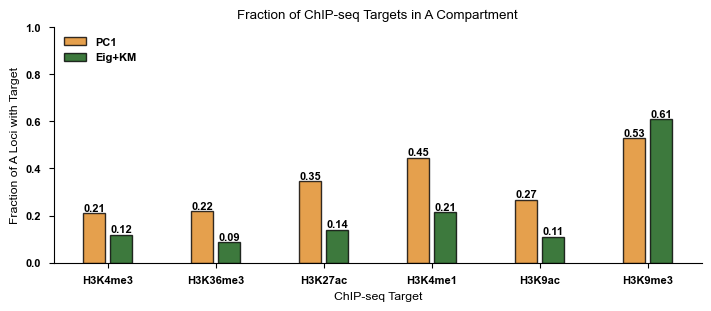

In [116]:
summ1_m = df.drop(["1D", "SnapFISH2"], axis=1).groupby("Su et al").mean()
summ1_m = summ1_m[up_rglt + down_rglt]
summ2_m = df.drop(["1D", "Su et al"], axis=1).groupby("SnapFISH2").mean()
summ2_m = summ2_m[up_rglt + down_rglt]
plt_df1 = summ1_m.T.reset_index(names=["Marker"]).melt(
    id_vars=["Marker"], var_name="Cpmt", value_name="frac"
)
plt_df1["Cpmt"] = plt_df1["Cpmt"].map({0:"A", 1:"B"})
plt_df1["Method"] = "PC1"
plt_df2 = summ2_m.T.reset_index(names=["Marker"]).melt(
    id_vars=["Marker"], var_name="Cpmt", value_name="frac"
)
plt_df2["Cpmt"] = plt_df2["Cpmt"].map({0:"A", 1:"B"})
plt_df2["Method"] = "Eig+KM"
plt_df = pd.concat([plt_df1, plt_df2], ignore_index=True)

fig, ax = plt.subplots(figsize=(7, 3))
sns.barplot(
    plt_df[plt_df["Cpmt"]=="A"], x="Marker", y="frac", hue="Method",  ax=ax, 
    width=.5, dodge=10, gap=0.2, alpha=.8, edgecolor="k", linewidth=1,
    palette={"PC1": "darkorange", "Eig+KM": "darkgreen"},
)
ax.bar_label(
    ax.containers[0], labels=ax.containers[0].datavalues.round(2), fontsize=8
)
ax.bar_label(
    ax.containers[1], labels=ax.containers[1].datavalues.round(2), fontsize=8
)
ax.legend(loc="upper left")
ax.set(xlabel="ChIP-seq Target", ylabel="Fraction of A Loci with Target")
ax.set(ylim=(0,1), title="Fraction of ChIP-seq Targets in A Compartment")
out_name = os.path.join(out_dire, "chr2_100tr_frac.pdf")
fig.savefig(out_name, bbox_inches="tight")

## With random errors in x and y

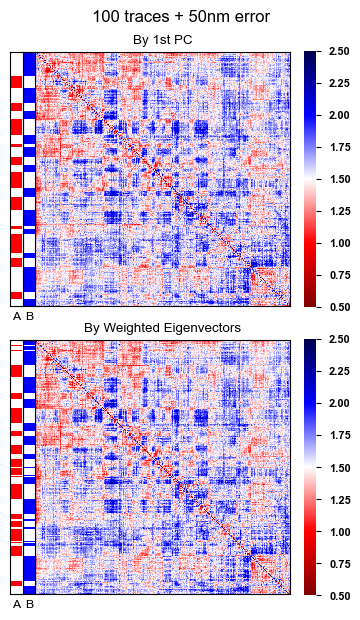

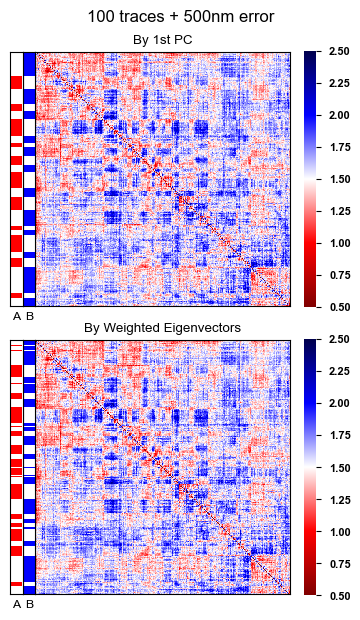

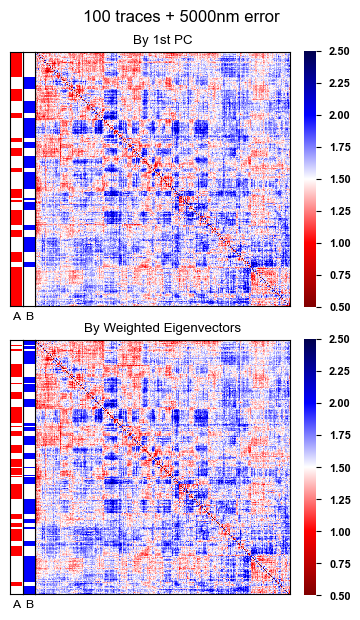

In [25]:
for n in [50, 500, 5000]:
    noised = mfr[("Trace_ID", 0, 100)].copy()
    np.random.seed(100)
    noised["X"] += stats.norm.rvs(size=(len(noised)), scale=n)
    noised["Y"] += stats.norm.rvs(size=(len(noised)), scale=n)

    abc = sf.domain.ABCaller(noised, 0, "carr")
    res1 = abc.by_first_pc(cutoff=500, sigma=1.9)
    res2 = abc.by_axes_pc()

    fig, axes = plt.subplots(2, 1, figsize=(3.5,6))
    fig.suptitle(f"100 traces + {n}nm error")
    sf.pl.pairwise_heatmap(med_dist_norm, ax=axes[0], rasterized=True, vmin=.5, vmax=2.5)
    axes[0].set(title="By 1st PC")
    sf.pl.plot_AB_bars(res1["chr2"][1], axes[0])

    sf.pl.pairwise_heatmap(med_dist_norm, ax=axes[1], rasterized=True, vmin=.5, vmax=2.5)
    axes[1].set(title="By Weighted Eigenvectors")
    sf.pl.plot_AB_bars(res2["chr2"][1], axes[1])
    out_name = os.path.join(out_dire, f"chr2_100tr_noised{n}nm.pdf")
    fig.savefig(out_name, bbox_inches="tight")

In [ ]:
from dask.distributed import Client, progress
client = Client(threads_per_worker=4, n_workers=1)

In [ ]:
client.cluster.scale(10)

In [25]:
import dask.array as da
import snapfish2 as sf

carr = sf.tl.ChromArray(mfr[("Trace_ID",0,100)])
carr.load_write("carr")

In [23]:
carr.arr

dask.array<from-zarr, shape=(100, 3, 935, 935), dtype=float64, chunksize=(100, 3, 204, 204), chunktype=numpy.ndarray>

CPU times: user 9.44 s, sys: 1.83 s, total: 11.3 s
Wall time: 2.03 s


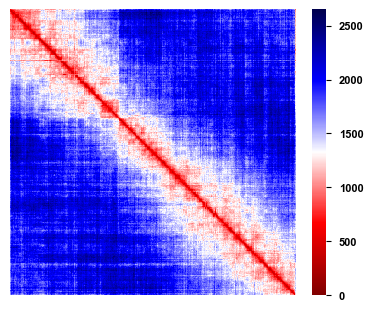

In [10]:
%%time
pdiff = da.square(carr.arr)
pdist = da.nanmedian(da.sqrt(da.sum(pdiff, axis=1)), axis=0).compute()
fig, ax = plt.subplots(figsize=(4, 3))
sf.pl.pairwise_heatmap(pdist, title="", ax=ax)

In [49]:
carr.close()

In [18]:
n, p, d = carr.X.shape

c = round(1 * (n * d * 8 / 1e8) ** -0.5)
X_da = da.from_array(carr.X, chunks=(n, c, p))
_arr = da.stack([
    (X_da[:,:,None,:] - X_da[:,None,:,:]).transpose(0,3,1,2)
], axis=0).squeeze()

In [29]:
ip1, i1, ip2, i2 = 0, 100, 300, 100
csl1 = slice(ip1, ip1+i1)
csl2 = slice(ip2, ip2+i2)
aa = np.stack([
    (x1.T[:,None,:] - x2.T[:,:,None]).transpose((0,2,1))
    for x1, x2 in zip(carr._X[:,csl1,:], carr._X[:,csl2,:])
])

In [36]:
aa[0]

array([[[  770.,   921.,   754., ...,   202.,   691.,   607.],
        [  479.,   630.,   463., ...,   -89.,   400.,   316.],
        [  494.,   645.,   478., ...,   -74.,   415.,   331.],
        ...,
        [  907.,  1058.,   891., ...,   339.,   828.,   744.],
        [  820.,   971.,   804., ...,   252.,   741.,   657.],
        [  859.,  1010.,   843., ...,   291.,   780.,   696.]],

       [[ -477.,  -813.,  -718., ..., -1306., -1118., -1306.],
        [ -250.,  -586.,  -491., ..., -1079.,  -891., -1079.],
        [ -480.,  -816.,  -721., ..., -1309., -1121., -1309.],
        ...,
        [ -565.,  -901.,  -806., ..., -1394., -1206., -1394.],
        [ -541.,  -877.,  -782., ..., -1370., -1182., -1370.],
        [ -542.,  -878.,  -783., ..., -1371., -1183., -1371.]],

       [[-1131., -1714., -1658., ...,   263.,   308.,   721.],
        [ -913., -1496., -1440., ...,   481.,   526.,   939.],
        [-1553., -2136., -2080., ...,  -159.,  -114.,   299.],
        ...,
        [ -4

In [37]:
bb = (carr._X[:,None,csl1,:] - carr._X[:,csl2,None,:]).transpose(0,3,2,1)

np.allclose(aa, bb, equal_nan=True)

True